In [1]:
import numpy as np
import pandas as pd
import re
from geocodio import GeocodioClient
client = GeocodioClient('0f669aa4d57d7dab0ba9b8dd049a9957678985d')



/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/cffi/model.py:525: UserWarning: 'point_conversion_form_t' has no values explicitly defined; guessing that it is equivalent to 'unsigned int'
  % self._get_c_name())


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
#  dtype={'Funding': np.float64},
kyf2 = pd.read_excel('KYF2 new compass data 2015.xls', na_values="No Data",
                     skip_footer=2, encoding='xlrd', parse_dates=['Year'])


In [111]:
kyf2.describe()

,Funding,lon,lat,Cooking,Tourism,Food Deserts,Beef,Alcohol,Bees,Youth,Beginning Farmers,Organic,Blueberries,Heritage,Soilless,Logo/Branding,grant,loan
count,4.176000e+03,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000
mean,1.375187e+05,-92.731725,39.381220,0.049090,0.019636,0.020354,0.016044,0.026820,0.004310,0.121408,0.030891,0.031130,0.006466,0.007423,0.005029,0.017960,0.971743,0.028257
std,5.339381e+05,20.650350,6.156687,0.216082,0.138763,0.141226,0.125660,0.161576,0.065519,0.326640,0.173043,0.173691,0.080158,0.085849,0.070744,0.132821,0.165725,0.165725
min,3.920000e+02,-170.702496,-14.278056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000e+04,-104.896001,36.332120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5.201035e+04,-88.929301,39.877513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.996000e+04,-78.629303,43.003034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.970000e+07,144.824719,64.852226,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# convert categories to boolean values
bool_columns = ['Cooking','Tourism','Food Deserts','Beef','Alcohol','Bees','Youth',
                'Beginning Farmers','Organic','Blueberries', 'Heritage','Soilless','Logo/Branding']
kyf2[bool_columns] = kyf2[bool_columns].fillna(value=0)
kyf2[bool_columns] = kyf2[bool_columns].astype(int)


In [ ]:
# rename columns
kyf2.rename(columns={'X': 'lon', 'Y':'lat'}, inplace=True)
# kyf2.reset_index(inplace=True)
# kyf_for_geocodio = kyf2[['index',  'lat', 'lon', 'Address', 'State', 'Town', 'Zip']]
# kyf_for_geocodio.to_csv('kyf2latlon1.csv', encoding='utf-8')


In [24]:
kyf2.head(2)

,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,...,Beef,Alcohol,Bees,Youth,Beginning Farmers,Organic,Blueberries,Heritage,Soilless,Logo/Branding
0,Alaska Cooperative Development Program,Rural Cooperative Development Grants,RCDG,2009-01-01,"Anchorage, AK",AK,Anchorage,,RBCS,Rural Development,...,0,0,0,0,0,0,0,0,0,0
1,Alaska Cooperative Development Program,Rural Cooperative Development Grants,RCDG,2010-01-01,"Anchorage, AK",AK,Anchorage,,RBCS,Rural Development,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# determine if Funding row has null values
# np.where(pd.isnull(kyf2.Funding))
# kyf2['Funding'].hasnans
# nan_rows = kyf2[kyf2.Funding.isnull()]
# nanFunding_rows = kyf2.Funding.dropna(axis=0, inplace=True)
# nanFunding_rows
# print kyf2.sample(6).iloc[:, 10:-10:].head(12)

# kyf2 = kyf2[pd.notnull(kyf2['Funding'])]
# pd.notnull(kyf2['Funding'])
# Drop the nine records with no data for Funding
kyf2 = kyf2.dropna(subset=['Funding'])


In [41]:
print '--- Count by Year ---'
print kyf2.Year.value_counts().sort_index()
print '--- Count by Funding_Ty value ---'
print kyf2.Funding_Ty.value_counts().sort_index()
print '--- Column list ---'
print kyf2.columns


--- Count by Year ---
2009-01-01    532
2010-01-01    730
2011-01-01    777
2012-01-01    654
2013-01-01    507
2014-01-01    976
Name: Year, dtype: int64
--- Count by Funding_Ty value ---
Grant     4053
Grants       4
Loan       118
grant        1
Name: Funding_Ty, dtype: int64
--- Column list ---
Index([            u'Title',              u'Name',        u'Abbreviati',
                    u'Year',           u'Address',             u'State',
                    u'Town',               u'Zip',            u'Agency',
              u'Mission_Ar',         u'Recipient',        u'Recipient_',
                 u'Funding',        u'Funding_Ty',       u'Description',
                 u'Topic_A',           u'Topic_B',           u'Topic_C',
              u'More_infor',               u'lon',               u'lat',
                 u'Cooking',           u'Tourism',      u'Food Deserts',
                    u'Beef',           u'Alcohol',              u'Bees',
                   u'Youth', u'Beginning Fa

In [19]:
# create a file of all the awardees that were not geocoded
lon_zero = kyf2[kyf2['lon']==0.0]
lon_zero.to_csv('lon_zero.csv', encoding='utf-8')

In [20]:
# import the dataset of ungeocoded records
lon_zero4geocoding = pd.read_csv('lon_zero.csv', encoding='utf-8')
lon_zero4geocoding['Zip'] = lon_zero4geocoding.Zip.astype(str)
lon_zero4geocoding

,Unnamed: 0,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,...,Beef,Alcohol,Bees,Youth,Beginning Farmers,Organic,Blueberries,Heritage,Soilless,Logo/Branding
0,209,Southern Arizona Beekeeping and Honey Promotio...,Local Food Promotion Program,LFPP,2014-01-01,"4526 N. Anway, Rd.",AZ,Marana,85753,AMS,...,0,0,1,0,0,0,0,0,0,0
1,578,Sweetgrass Cooperative,Value-Added Producer Grants,VAPG,2011-01-01,"81223, Cotopaxi, CO",CO,Hillside,82132,RBCS,...,1,0,0,0,0,0,0,0,0,0
2,596,Downtown Norwich Farmer’s Market Operation Hea...,Farmers Market Promotion Program,FMPP,2014-01-01,77 Main Street,CT,Norwich,63605,AMS,...,0,0,0,0,0,0,0,0,0,0
3,603,"Hartford Mobile Market--Bringing Fresh, Local ...",Local Food Promotion Program,LFPP,2014-01-01,1 Congress Street,CT,Hartford,61141,AMS,...,0,0,0,0,0,0,0,0,0,0
4,613,Noank Community Market Local Meat Initiative,Local Food Promotion Program,LFPP,2014-01-01,17 Pearl Street,CT,Groton,63405,AMS,...,0,0,0,0,0,0,0,0,0,0
5,1385,CCK Commissary @ Pearl (CCKC@P): A social vent...,Local Food Promotion Program,LFPP,2014-01-01,594 Columbia Road,MA,Dorchester,21253,AMS,...,0,0,0,0,0,0,0,0,0,0
6,1438,Local Farms to Low Income Urban Communities: a...,Local Food Promotion Program,LFPP,2014-01-01,17 Ashmont Street,MA,Dorchester,21243,AMS,...,0,0,0,0,0,0,0,0,0,0
7,1475,Southern New England Meat Processing Initiative,Local Food Promotion Program,LFPP,2014-01-01,22 Jordan Rd.,MA,South Dartmouth,27481,AMS,...,0,0,0,0,0,0,0,0,0,0
8,1476,Southwestern Worcester County Food Hub Feasibi...,Local Food Promotion Program,LFPP,2014-01-01,2 Washington Square,MA,Worcester,16044,AMS,...,0,0,0,0,0,0,0,0,0,0
9,1508,"Butterbee Farm, LLC",Value-Added Producer Grants,VAPG,2014-01-01,1173 Goldfinch Lane,MD,MILLERSVILLE,21180,RBCS,...,0,0,0,0,0,0,0,0,0,0


In [21]:
address_cols = ['Unnamed: 0','Address','Town','State','Zip']
df = lon_zero4geocoding[address_cols]
# df.reset_index(inplace=True)
df['full_address'] =  df['Address'] \
+", " + df['Town'] + ", " \
+ df['State'] + " " \
+ df['Zip']

#extract for list of index numbers for geocoding
lon_zero_list = df.iloc[:, -1].tolist()
lon_zero_list
# geocode the awardees that had a longitude of 0
# geocoded = client.geocode(lon_zero_list)
df


/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unnamed: 0,Address,Town,State,Zip,full_address
0,209,"4526 N. Anway, Rd.",Marana,AZ,85753,"4526 N. Anway, Rd., Marana, AZ 85753"
1,578,"81223, Cotopaxi, CO",Hillside,CO,82132,"81223, Cotopaxi, CO, Hillside, CO 82132"
2,596,77 Main Street,Norwich,CT,63605,"77 Main Street, Norwich, CT 63605"
3,603,1 Congress Street,Hartford,CT,61141,"1 Congress Street, Hartford, CT 61141"
4,613,17 Pearl Street,Groton,CT,63405,"17 Pearl Street, Groton, CT 63405"
5,1385,594 Columbia Road,Dorchester,MA,21253,"594 Columbia Road, Dorchester, MA 21253"
6,1438,17 Ashmont Street,Dorchester,MA,21243,"17 Ashmont Street, Dorchester, MA 21243"
7,1475,22 Jordan Rd.,South Dartmouth,MA,27481,"22 Jordan Rd., South Dartmouth, MA 27481"
8,1476,2 Washington Square,Worcester,MA,16044,"2 Washington Square, Worcester, MA 16044"
9,1508,1173 Goldfinch Lane,MILLERSVILLE,MD,21180,"1173 Goldfinch Lane, MILLERSVILLE, MD 21180"


In [86]:
# create a DataFrame of latitudes and longitudes
# in the same order as the original extracted list
# awardee_geocodes = {}
# counter = 0
# for awardee in geocoded:
#     awardee_geocodes[counter] = {}

#     results = awardee.values()[1][0]
#     latitude = results['location']['lat']
#     longitude = results['location']['lng']
#     awardee_geocodes[counter]['latitude'] = latitude
#     awardee_geocodes[counter]['longitude'] = longitude
#     counter +=1
# awardee_geocodes
# awardee_geocodes_df = pd.DataFrame(awardee_geocodes).T
# awardee_geocodes_df

geocoded['coords']=tuple(zip(geocoded.latitude, geocoded.longitude))
sample_loclist = geocoded['coords'].tolist()
sample_loclist

AttributeError: 'LocationCollection' object has no attribute 'latitude'

In [15]:
#append the latitude and longitude to the previously ungeocoded addresses
joined_geo_df = df.join(awardee_geocodes_df)
joined_geo_df.set_index('Unnamed: 0', inplace=True)
joined_geo_df

,Address,Town,State,Zip,full_address,latitude,longitude
Unnamed: 0,,,,,,,
209,"4526 N. Anway, Rd.",Marana,AZ,85753,"4526 N. Anway, Rd., Marana, AZ 85753",32.287767,-111.321275
578,"81223, Cotopaxi, CO",Hillside,CO,82132,"81223, Cotopaxi, CO, Hillside, CO 82132",38.265280,-105.611670
596,77 Main Street,Norwich,CT,63605,"77 Main Street, Norwich, CT 63605",41.523525,-72.086211
603,1 Congress Street,Hartford,CT,61141,"1 Congress Street, Hartford, CT 61141",41.752879,-72.675953
613,17 Pearl Street,Groton,CT,63405,"17 Pearl Street, Groton, CT 63405",41.325004,-71.987876
1385,594 Columbia Road,Dorchester,MA,21253,"594 Columbia Road, Dorchester, MA 21253",42.317333,-71.065083
1438,17 Ashmont Street,Dorchester,MA,21243,"17 Ashmont Street, Dorchester, MA 21243",42.288417,-71.054441
1475,22 Jordan Rd.,South Dartmouth,MA,27481,"22 Jordan Rd., South Dartmouth, MA 27481",41.532409,-70.999377
1476,2 Washington Square,Worcester,MA,16044,"2 Washington Square, Worcester, MA 16044",42.262307,-71.795076


In [51]:
# create a list of indeces for updating
to_update_list = list(joined_geo_df.index.values)
to_update_list

[209,
 578,
 596,
 603,
 613,
 1385,
 1438,
 1475,
 1476,
 1508,
 1581,
 1590,
 1598,
 1613,
 1639,
 2438,
 2465,
 2478,
 2479,
 3244,
 3741,
 3793]

In [27]:
for idx in to_update_list:
    kyf2.loc[idx, 'lat'] = joined_geo_df.loc[idx, 'latitude']
    kyf2.loc[idx, 'lon'] = joined_geo_df.loc[idx, 'longitude']


In [44]:
lon_zero = kyf2[kyf2['lon']==0.0]
print lon_zero[8:-12]
kyf2[8:-12].head()

Empty DataFrame
Columns: [Title, Name, Abbreviati, Year, Address, State, Town, Zip, Agency, Mission_Ar, Recipient, Recipient_, Funding, Funding_Ty, Description, Topic_A, Topic_B, Topic_C, More_infor, lon, lat, Cooking, Tourism, Food Deserts, Beef, Alcohol, Bees, Youth, Beginning Farmers, Organic, Blueberries, Heritage, Soilless, Logo/Branding, grant, loan, grant_loan]
Index: []

[0 rows x 37 columns]


,Title,Name,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,...,Youth,Beginning Farmers,Organic,Blueberries,Heritage,Soilless,Logo/Branding,grant,loan,grant_loan
8,Chef at the Market,Specialty Crop Block Grants,SCBG,2011-01-01,"99645, Palmer, AK",AK,Palmer,99645,AMS,Marketing and Regulatory Programs,...,0,0,0,0,0,0,0,1,0,Grant
9,ChefDays Farmers Market Project,Specialty Crop Block Grants,SCBG,2012-01-01,"99501, Anchorage, AK",AK,Anchorage,99501,AMS,Marketing and Regulatory Programs,...,0,0,0,0,0,0,0,1,0,Grant
10,City of Wrangell Medical Center Community Gard...,Community Facilities,CF,2010-01-01,"99929, Wrangell, AK",AK,Wrangell,99929,RHS,Rural Development,...,0,0,0,0,0,0,0,1,0,Grant
11,Competitive Grant: Mat Su Farm Bureau & Chef ...,Specialty Crop Block Grants,SCBG,2010-01-01,"99645, Palmer, AK",AK,Palmer,99645,AMS,Marketing and Regulatory Programs,...,0,0,0,0,0,0,0,1,0,Grant
12,Competitive Grant: Homer Farmers Market,Specialty Crop Block Grants,SCBG,2010-01-01,"99645, Palmer, AK",AK,Palmer,99645,AMS,Marketing and Regulatory Programs,...,0,0,0,0,0,0,0,1,0,Grant


In [49]:
# display first 3 records, not including the last 16 columns
# print kyf2.sample(6).iloc[:, 12::].head(12)
# kyf2.iloc[1014:, 10:-3:].head(4)
kyf2.iloc[1474:, 2:-13:].head(2)

,Abbreviati,Year,Address,State,Town,Zip,Agency,Mission_Ar,Recipient,Recipient_,...,Description,Topic_A,Topic_B,Topic_C,More_infor,lon,lat,Cooking,Tourism,Food Deserts
1475,LFPP,2014-01-01,22 Jordan Rd.,MA,South Dartmouth,27481,AMS,Marketing and Regulatory Programs,Southeastern Massachusetts Livestock Associati...,Nonprofit,...,"LFPP will award $25,000 to the Southeastern Ma...","Meat, Poultry and Fish",Infrastructure,,,-70.999377,41.532409,0,0,0
1476,LFPP,2014-01-01,2 Washington Square,MA,Worcester,16044,AMS,Marketing and Regulatory Programs,Central Massachusetts Regional Planning Commis...,Nonprofit,...,"LFPP will award $25,000 to the Central Massach...",Research,Infrastructure,,,-71.795076,42.262307,0,0,0


In [12]:
kyf2.dtypes

Title                        object
Name                         object
Abbreviati                   object
Year                 datetime64[ns]
Address                      object
State                        object
Town                         object
Zip                          object
Agency                       object
Mission_Ar                   object
Recipient                    object
Recipient_                   object
Funding                     float64
Funding_Ty                   object
Description                  object
Topic_A                      object
Topic_B                      object
Topic_C                      object
More_infor                   object
lon                         float64
lat                         float64
Cooking                       int64
Tourism                       int64
Food Deserts                  int64
Beef                          int64
Alcohol                       int64
Bees                          int64
Youth                       

In [40]:
grantre = re.compile('grant.?', re.IGNORECASE)
# np.where(re.match(grantre, kyf2.Funding_Ty))
# kyf2.Funding_Ty.to_replace(grantre, "Grant")
kyf2['grant'] = np.where(kyf2.Funding_Ty.str.contains(grantre), 1,0)
print "Grants: ", sum(kyf2['grant'])
kyf2['loan'] = np.where(kyf2.Funding_Ty.str.contains('Loan'), 1,0)
print "Loans: ", sum(kyf2['loan'])
kyf2['grant_loan'] = np.where(kyf2.Funding_Ty.str.contains(grantre), "Grant","")
kyf2['grant_loan'] = np.where(kyf2.Funding_Ty.str.contains("Loan"), "Loan",kyf2['grant_loan'])
kyf2['grant_loan'].value_counts(dropna=False)
kyf2[['Funding_Ty','grant_loan']].sample(5).head(5)

Grants:  4058
Loans:  118


,Funding_Ty,grant_loan
2678,Grant,Grant
3729,Grant,Grant
583,Grant,Grant
3176,Grant,Grant
1140,Grant,Grant


In [46]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '${:,.2f}'.format
print pd.DataFrame(kyf2.groupby(['grant_loan']).Funding.mean()) \
.join(pd.DataFrame(kyf2.grant_loan.value_counts()))

                 Funding  grant_loan
grant_loan                          
Grant         $89,918.68        4058
Loan       $1,774,474.42         118


In [48]:
pd.options.display.float_format = None

1.4.3


/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


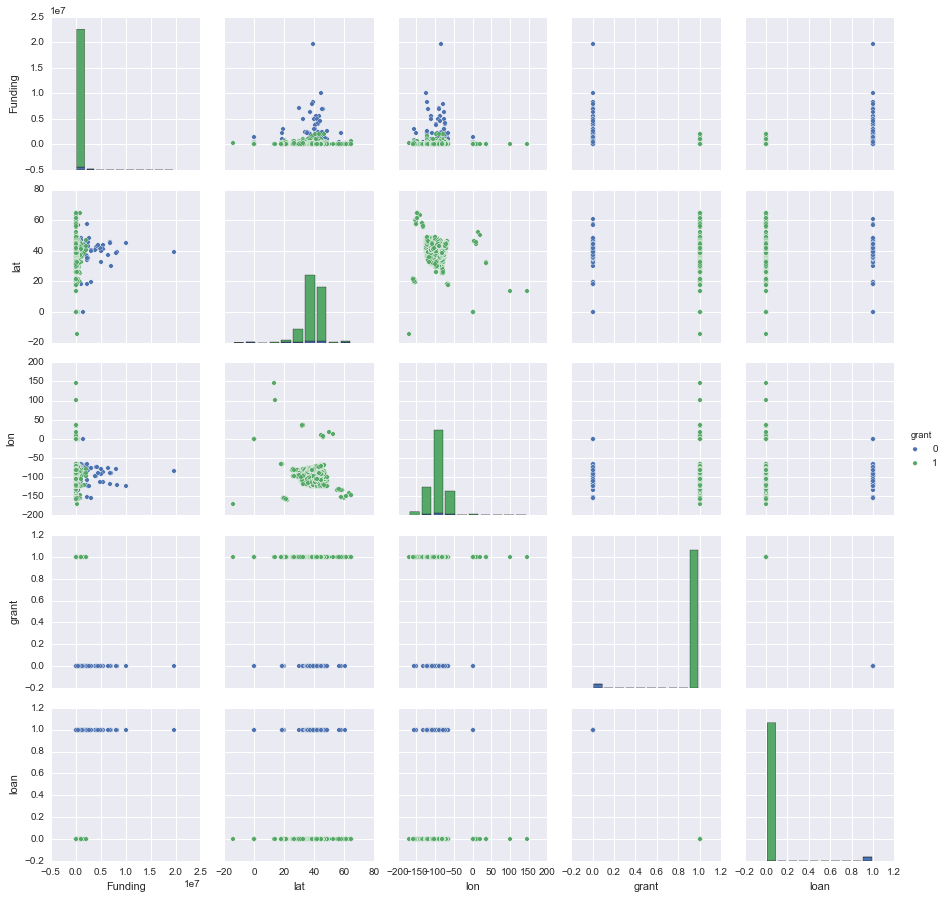

In [14]:
print matplotlib.__version__
pair_data_cols = ['Funding', 'lat', 'lon','grant','loan','Year']
kyf2_nums = kyf2[pair_data_cols]
# sns.pairplot(kyf2.iloc[:, :-14:], hue='grant_loan')

sns.pairplot(kyf2_nums, hue='grant')
# kyf2_nums

In [35]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
# 'en_US'
locale.format("%d", 1255000, grouping=True)
# '1,255,000'

'1,255,000'

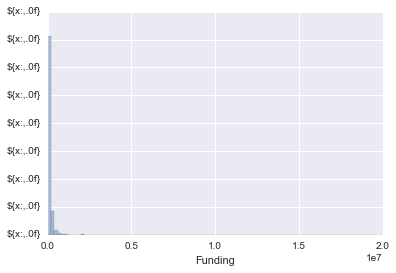

In [48]:
# # sns.plt.ticklabel_format(style='plain', axis='both',useOffset=False)
# from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
# # ax = plt.gca()
# fig, ax = plt.subplots(1, 1)

# # ax.xaxis.set_major_formatter(FormatStrFormatter('$%0.2f'))
# fmt = '${x:,.0f}'
# # tick = StrMethodFormatter(fmt)
# ax.xaxis.set_major_formatter(fmt)


from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('${x:,.0f}'))
sns.distplot(kyf2['Funding'], kde=False, bins =100)

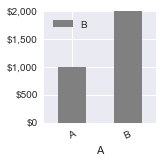

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df = pd.DataFrame({'A': ['A', 'B'], 'B': [1000,2000]})

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
df.plot(kind='bar', x='A', y='B',
        align='center', width=.5, edgecolor='none', 
        color='grey', ax=ax)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

plt.show()

In [31]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
money = [1.5e5, 2.5e6, 5.5e6, 2.0e7]def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
plt.bar(x, money)
plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
plt.show()

SyntaxError: invalid syntax (<ipython-input-31-40a85207773a>, line 6)

/Users/marjorieroswell/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


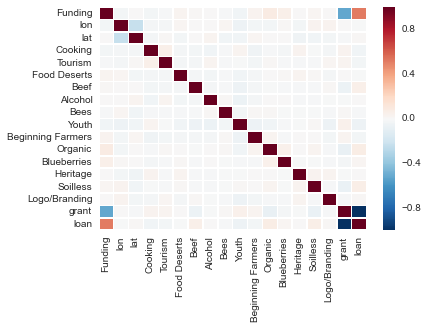

In [12]:
corr = kyf2.corr()
sns.heatmap(corr, linewidths= 0.25)

In [62]:
locations = kyf2[['lat', 'lon']].sample(60).head(100)
locationlist = locations.values.tolist()
print locations

            lat         lon
1835  43.121218  -89.347059
2083  33.416563  -91.026607
807   32.835354  -83.636787
3294  33.924340  -80.342362
792   32.574814  -84.243950
2465  39.966668  -74.636054
530   39.368891 -107.192748
2601  39.499914 -119.778977
3207  18.219841  -66.594159
1203  39.770591  -86.156178
180   32.700224 -114.645627
3593  40.760583 -111.897359
651   39.201099  -75.557015
2980  44.947767 -123.008199
3488  32.996414  -96.791778
3569  40.520491 -111.472378
1645  42.257253  -84.110452
1635  46.684298  -68.007589
3123  41.071412  -79.416258
1471  42.359862  -71.054668
676   38.678721  -75.387607
1599  46.127529  -67.869970
1221  39.699780  -86.390830
680   29.651979  -82.319031
3573  41.728633 -111.834991
3446  36.064678  -86.749401
587   39.708245 -105.037079
1856  45.184259  -95.298938
2817  39.999637  -83.034566
360   38.553294 -121.757297
2161  35.591647  -82.564094
4029  44.531756  -88.049518
2713  42.982601  -74.963031
2239  35.847194  -78.629320
2700  41.521263  -74

In [57]:
locations['coords']=tuple(zip(locations.lat, locations.lon))
loclist = locations['coords'].tolist()
# coordscol = locations['coords']
# coordscol.tolist
loclist

[(44.722043999999997, -73.469779000000003),
 (38.579788000000001, -121.493729),
 (42.107503999999999, -86.424638000000002),
 (44.248753000000001, -73.205028999999996),
 (36.708790999999998, -81.980266999999998),
 (40.940640999999999, -72.638840999999999),
 (44.475921, -73.213232000000005),
 (38.265594, -122.031181),
 (35.498311000000001, -97.503157999999999),
 (41.34937, -83.116707000000005),
 (40.452199999999998, -74.481408999999999),
 (40.531669999999998, -105.07256099999999),
 (38.739919999999998, -90.315636999999995),
 (46.825237000000001, -100.89932),
 (61.599490000000003, -149.12134699999999),
 (42.455309999999997, -75.060271),
 (47.610593999999999, -122.341866),
 (45.539546000000001, -122.94082899999999),
 (39.740243999999997, -121.84645),
 (38.579788000000001, -121.493729),
 (41.600411999999999, -93.665677000000002),
 (47.447645999999999, -99.108508999999998),
 (39.546030999999999, -107.323702),
 (44.513711999999998, -72.376227999999998),
 (39.770591000000003, -86.1561779999999

In [58]:
locations['coords']

2789     (44.722044, -73.469779)
446     (38.579788, -121.493729)
1756     (42.107504, -86.424638)
3754     (44.248753, -73.205029)
3661     (36.708791, -81.980267)
2691     (40.940641, -72.638841)
3773     (44.475921, -73.213232)
476     (38.265594, -122.031181)
2912     (35.498311, -97.503158)
2803      (41.34937, -83.116707)
2493       (40.4522, -74.481409)
557      (40.53167, -105.072561)
1939      (38.73992, -90.315637)
2310     (46.825237, -100.89932)
40       (61.59949, -149.121347)
2745      (42.45531, -75.060271)
3882    (47.610594, -122.341866)
2989    (45.539546, -122.940829)
426      (39.740244, -121.84645)
482     (38.579788, -121.493729)
917      (41.600412, -93.665677)
2314     (47.447646, -99.108509)
524     (39.546031, -107.323702)
3805     (44.513712, -72.376228)
1184     (39.770591, -86.156178)
2220     (35.904922, -78.748739)
1733     (42.726754, -84.479071)
3080     (39.947954, -76.802558)
2940    (44.545548, -123.282399)
2274       (35.77488, -78.63503)
1678     (

In [126]:
# Get two sample geocodes from each state
each_state = kyf2.groupby('State').head(2).loc[:, ["lat", 'lon']]
# sample_geo_2 = sample_geo.reset_index()

each_state['coords']=tuple(zip(each_state.lat, each_state.lon))
each_state_list = each_state['coords'].tolist()
each_state_list

# counter = 0
# geo_dict = {}
# for sampleloc in sample_geo_2:
#     geo_dict[counter] = {}
# #     geo_dict[counter]['latitude'] = sampleloc['latitude']
# #     geo_dict[counter]['longitude'] = sampleloc['longitude']
#     counter+=1
#     print sampleloc
# print geo_dict

[(61.217559000000001, -149.85838000000001),
 (61.217559000000001, -149.85838000000001),
 (32.421607000000002, -86.228882999999996),
 (32.378701999999997, -86.278250999999997),
 (34.758693000000001, -92.386210000000005),
 (34.746091999999997, -92.277360999999999),
 (1.9999999999999999e-06, -1.9999999999999999e-06),
 (1.9999999999999999e-06, -1.9999999999999999e-06),
 (35.629860999999998, -109.064181),
 (32.377212, -112.86284999999999),
 (38.579788000000001, -121.493729),
 (38.579788000000001, -121.493729),
 (38.889648000000001, -105.914638),
 (38.112662999999998, -104.031978),
 (41.305180999999997, -72.923850000000002),
 (41.768571000000001, -72.520662000000002),
 (38.932422000000003, -77.032127000000003),
 (38.907589999999999, -77.018839999999997),
 (39.201098999999999, -75.557015000000007),
 (39.201098999999999, -75.557015000000007),
 (30.412493999999999, -84.283068),
 (29.651979000000001, -82.319030999999995),
 (33.745891, -84.387691000000004),
 (33.949691000000001, -83.3747180000000

In [109]:
sample_states_geo = client.reverse(each_state, fields=['cd', 'stateleg', 'census'])
sample_states_geo.formatted_addresses


['',
 u'Coden, AL 36523',
 u'Atlanta, TX 75551',
 u'Pago Pago, AS 96799',
 '',
 '',
 u'Redmesa, CO 81326',
 u'778 E 1450th Rd, Lawrence, KS 66046',
 u'646 Beverly Dr, Alexandria, VA 22305',
 u'2220 Farm Creek Rd, Toddville, MD 21672',
 '',
 u'4196 Big Oak Dr, Greenwood, FL 32443',
 '',
 u'672 N Aohoku Pl, Hilo, HI 96720',
 '',
 u'Larue, TX 75770',
 u'McDermitt, NV 89421',
 u'Lake Spring, MO 65532',
 u'9199 Kost Rd, Elberfeld, IN 47613',
 u'133 SW 9th St, Topeka, KS 66612',
 u'Moscow, KS 67952',
 u'Hardin, KY 42048',
 u'Hackberry, LA 70645',
 u'113 Co Rd 518, Silex, MO 63377',
 '',
 u'255 Little River Rd, Craigsville, VA 24430',
 u'Three Notch, AL 36053',
 '',
 u'933 Old Taylor Rd, Oxford, MS 38655',
 u'Thurston, NE 68062',
 u'Golden, TX 75444',
 '',
 u'Sulphur, LA 70663',
 u'Warm Lake, ID 83611',
 u'Northfield, TX 79201',
 u'Selfridge, ND 58568',
 u'Palisade, NE 69040',
 '',
 u'249 Fairfax Pl, New Orleans, LA 70131',
 u'Animas, NM 88020',
 u'Hanford, CA 93231',
 u'Cochrans Mills, PA 16

In [107]:
samplegeo

[{u'results': [{u'accuracy': 0.06,
    u'accuracy_type': u'nearest_place',
    u'address_components': {u'city': u'Fort Robinson',
     u'country': u'US',
     u'county': u'Sioux County',
     u'state': u'NE',
     u'zip': u'69339'},
    u'fields': {u'census': {u'block_code': u'1102',
      u'block_group': u'1',
      u'census_year': 2015,
      u'county_fips': u'31165',
      u'place_fips': u'3117285',
      u'state_fips': u'31',
      u'tract_code': u'950100'},
     u'congressional_district': {u'congress_number': u'115th',
      u'congress_years': u'2017-2019',
      u'district_number': 3,
      u'name': u'Congressional District 3'},
     u'state_legislative_districts': {u'senate': {u'district_number': u'47',
       u'name': u'State Senate District 47'}}},
    u'formatted_address': u'Fort Robinson, NE 69339',
    u'location': {u'lat': 42.790513, u'lng': -103.504829},
    u'source': u'TIGER/Line\xae dataset from the US Census Bureau'}]},
 {u'results': [{u'accuracy': 1,
    u'accuracy_t

In [53]:
kyfgeo = client.reverse(loclist, fields=["cd", "stateleg", 'census'])
# kyfgeo.get('32.372458,-81.557286')
type(kyfgeo)
df_addresses = pd.DataFrame(kyfgeo.formatted_addresses)
df_addresses

NameError: name 'loclist' is not defined

In [67]:
details = {}
counter = 0
for loc in kyfgeo:
    details[counter] = {}

    results = loc.values()[0][0]
    fields = results['fields']
    census= fields['census']    
    
    census_year = census['census_year']
    state_fips = census['state_fips']
    county_fips = census['county_fips']
    place_fips = census['place_fips']
    tract_code = census['tract_code']
    block_code = census['block_code']
    block_group = census['block_group']
    
    accuracy = results['accuracy']
    accuracy_type = results['accuracy_type']
    details[counter]['census_year'] = census_year
    details[counter]['state_fips'] = state_fips
    details[counter]['county_fips'] = county_fips
    details[counter]['place_fips'] = place_fips
    details[counter]['tract_code'] = tract_code
    details[counter]['census_year'] = block_group
    details[counter]['accuracy'] = accuracy
    details[counter]['accuracy_type'] = accuracy_type
    details[counter]['source'] = source    
    if loc.formatted_address[-8:-6] == 'DC':
        print "in DC"
        counter += 1
    if loc.formatted_address[-8:-6] == 'AS':
        print "in AS"
        flds = loc.values()[0][0]['fields']    
        cd=flds['congressional_district']['district_number']
        details[counter] = {}
        details[counter]['cd'] = cd
        counter += 1
    else:
        components = results['address_components']
        state = components['state']
        county = components['county']
        cd = fields['congressional_district']['district_number']
        sl = fields['state_legislative_districts']['house']['district_number']
        su = fields['state_legislative_districts']['senate']['district_number']

        source = results['source']
        details[counter]['state'] = state
        details[counter]['cd'] = cd
        details[counter]['sl'] = sl
        details[counter]['su'] = su
        details[counter]['county'] = county



        counter += 1
print details


# su = fields['state_legislative_districts']['senate']['district_number']
# sl = fields['state_legislative_districts']['house']['district_number']
# su_name = fields['state_legislative_districts']['senate']['name']
# sl_name = fields['state_legislative_districts']['house']['name']

# cty = results['address_components']['county']
# state = results['address_components']['state']




{0: {'county': u'Guilford County', 'county_fips': u'37081', 'census_year': u'2', 'sl': u'57', 'place_fips': u'3728000', 'cd': 13, 'state_fips': u'37', 'source': u'TIGER/Line\xae dataset from the US Census Bureau', 'state': u'NC', 'su': u'28', 'accuracy_type': u'nearest_street', 'tract_code': u'011000', 'accuracy': 1}, 1: {'county': u'Albany County', 'county_fips': u'56001', 'census_year': u'1', 'sl': u'45', 'place_fips': u'5645050', 'cd': 0, 'state_fips': u'56', 'source': u'TIGER/Line\xae dataset from the US Census Bureau', 'state': u'WY', 'su': u'10', 'accuracy_type': u'nearest_street', 'tract_code': u'963400', 'accuracy': 1}, 2: {'county': u'Pennington County', 'county_fips': u'27113', 'census_year': u'1', 'sl': u'1A', 'place_fips': u'2764570', 'cd': 7, 'state_fips': u'27', 'source': u'TIGER/Line\xae dataset from the US Census Bureau', 'state': u'MN', 'su': u'1', 'accuracy_type': u'nearest_street', 'tract_code': u'090200', 'accuracy': 1}, 3: {'county': u'Scott County', 'county_fips':

In [64]:
# pr_location = client.reverse((-66.405977,18.454233), fields=["cd", "stateleg", "census"])
as_location = client.reverse((-14.278056,-170.7025), fields=["cd", "stateleg", "census"])
as_location

{u'results': [{u'accuracy': 8466.56,
   u'accuracy_type': u'nearest_place',
   u'address_components': {u'city': u'Pago Pago',
    u'country': u'US',
    u'county': u'Eastern District',
    u'state': u'AS',
    u'zip': u'96799'},
   u'fields': {u'census': {u'block_code': u'2001',
     u'block_group': u'2',
     u'census_year': 2015,
     u'county_fips': u'60010',
     u'place_fips': u'6062500',
     u'state_fips': u'60',
     u'tract_code': u'950600'},
    u'congressional_district': {u'congress_number': u'115th',
     u'congress_years': u'2017-2019',
     u'district_number': 98,
     u'name': u'Delegate District (at Large)'},
    u'state_legislative_districts': []},
   u'formatted_address': u'Pago Pago, AS 96799',
   u'location': {u'lat': -14.278056, u'lng': -170.7025},
   u'source': u'TIGER/Line\xae dataset from the US Census Bureau'}]}

In [ ]:
fields = locations.values()[1][0]['fields']
cd = fields['congressional_district']['district_number']
sl = fields['state_legislative_districts']['house']['district_number']
su = fields['state_legislative_districts']['senate']['district_number']
type(fields)


locations.get('38.879138,-76.98187')[0]['congressional_district']

In [ ]:
geocoded_addresses[0]['results'][0]['location']

In [ ]:
sample_locations1 = client.reverse([
        (33.738987, -116.4083),
        (33.738987, -106.4083),
        (38.879138, -76.98187)
    ],  fields=["cd", "stateleg"])
sample_locations.lookups

In [ ]:
sample_locations.get((38.879138,-76.98187))

In [ ]:
sample_locations.formatted_addresses

In [52]:
sample_locations

NameError: name 'sample_locations' is not defined

In [ ]:
# locations.get('')
sample_locations.get('results')

In [ ]:
'''
{
'4324': '(37.3256, -105.63459),
'4356': {'lat': 0, 'lon': 180, 'district': 4}
}
'''

In [73]:
# withdistricts= client.geocode("3443 Guilford Terrace, Baltimore, MD 21218", fields=['cd', 'stateleg','census'])
# withdistricts= client.geocode("Pago Pago, AS 96799", fields=['cd', 'stateleg','census'])
withdistricts = client.reverse((-14.278056,-170.7025), fields=["cd", "stateleg", "census"])

# geo2.lookups
results = withdistricts.values()[0][0]
fields = results['fields']
census= fields['census']
cd = fields['congressional_district']['district_number']
# su = fields['state_legislative_districts']['senate']['district_number']
# sl = fields['state_legislative_districts']['house']['district_number']
# su_name = fields['state_legislative_districts']['senate']['name']
# sl_name = fields['state_legislative_districts']['house']['name']
cty = results['address_components']['county']
state = results['address_components']['state']
accuracy = results['accuracy']
accuracy_type = results['accuracy_type']
source = results['source']
census_year = census['census_year']
state_fips = census['state_fips']
county_fips = census['county_fips']
place_fips = census['place_fips']
tract_code = census['tract_code']
block_code = census['block_code']
block_group = census['block_group']

# withdistricts.accuracy
# withdistricts.values()
# # withdistricts.fields
withdistricts.values()
# print cd, su, sl, su_name, sl_name, cty, state, accuracy, accuracy_type, source, census_year,state_fips,county_fips,place_fips,tract_code,block_code,block_group
print cd, cty, state, accuracy, accuracy_type, source, census_year,state_fips,county_fips,place_fips,tract_code,block_code,block_group



98 Eastern District AS 8466.56 nearest_place TIGER/Line® dataset from the US Census Bureau 2015 60 60010 6062500 950600 2001 2
